### Image Classification

1. Pull the raw image data from Flickr and create local copies of the images
2. Convert the images in to raw rgb arrays and labels
3. Label images

### Datasets
 - [Eating Behavior Laboratory](https://sites.google.com/site/eatingandanxietylab/resources/food-pics)
 - [Pittsburg Fast Food Image Dataset](http://pfid.rit.albany.edu/)
 - [Ottowa Food Detection Dataset](http://www.site.uottawa.ca/~shervin/food/)
 - [Food 101 Dataset](https://www.vision.ee.ethz.ch/datasets_extra/food-101/)
 - [Japanese Food Dataset](http://foodcam.mobi/dataset256.html)

In [2]:
from os import listdir
from os.path import isfile, join
import math

from PIL import Image
from scipy import misc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import pymongo
import urllib

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Personal Food Photos

In [3]:
client = pymongo.MongoClient('localhost', 27017)
db = client.phronesis_food_photos

In [221]:
photos = db.remote_photos.find()
photodf = pd.DataFrame(list(photos))

In [205]:
photodf['label'] = photodf.title.apply(lambda t: t['_content'].lower())
photodf['url'] =  photodf.urls.apply(lambda u: u['url'][0]['_content'])
photodf['url'] = photodf.apply(create_download_link, 1)
photodf['timestamp'] = photodf.dates.apply(lambda u: pd.to_datetime(u['taken']))

In [206]:
pdf = photodf.loc[:, ['label', 'timestamp', 'url', 'farm', 'server', 'secret', 'id']]

In [211]:
# db.clean_photo_data.insert(pdf.to_dict(orient='records'))

In [190]:
def create_download_link(row):
    return "https://c2.staticflickr.com/%s/%s/%s_%s_q_d.jpg" % (row['farm'], row['server'], row['id'], row['secret'])

In [214]:
def save_image(row):
    template = "https://c2.staticflickr.com/%s/%s/%s_%s_q_d.jpg" % (row['farm'], row['server'], row['id'], row['secret'])
    filename = '../data/photos/%s.jpg' % row['id']
    urllib.urlretrieve(template, filename)

In [267]:
def show_image(img):
    img = np.swapaxes(img, 2, 0)
    plt.imshow(img)

In [274]:
# Fetch and save the images
# pdf.apply(save_image, 1)

In [8]:
path = '../data/photos/'
filenames = [f for f in listdir(path) if isfile(join(path, f))]

In [20]:
# image_data = np.array([misc.imread('../data/photos/' + img) for img in filenames[:20]])

In [15]:
swapped_image_data = np.swapaxes(image_data, 3, 1)

In [143]:
zipped_food_data = zip(swapped_image_data, pdf.title_text.as_matrix()[np.newaxis].T)

In [147]:
labeled_images = pdf[~pdf.title_text.isin(['', 'image'])]

In [150]:
labeled_ixs = labeled_images.index

In [163]:
clean_data = np.array(zipped_food_data)[labeled_ixs]

### Categorized Data

In [4]:
top_categories = [
    'coffee', 'beer','burrito','pizza','salad',
    'diet soda','veggie sausage','chips','red curry',
    'cheese sandwich','apple','juice','flax seed oil','pasta',
    'soup', 'pad thai', 'tea', 'tacos', 'quesadilla'
]

In [100]:
categories = top_categories[:10]

In [101]:
clean_photo_data = list(db.clean_photo_data.find({'category': {'$in': categories}}, {'_id': 0}))

In [114]:
cdf = pd.DataFrame(clean_photo_data)

In [115]:
filenames = list(cdf[cdf.category.notnull()].id.apply(lambda f: '../data/photos/' + f + '.jpg' ))

In [116]:
classes = pd.factorize(cdf[cdf.category.notnull()].category.as_matrix())[0]
labels = pd.factorize(cdf[cdf.category.notnull()].category.as_matrix())[1]

In [117]:
image_data = np.array([misc.imread(img) for img in filenames])

In [118]:
swapped_image_data = np.swapaxes(image_data, 3, 1)

In [119]:
def frac(arr, perc):
    return int(math.floor(len(arr) * perc))

In [120]:
def test_train_split(X, y, train_size=None):
    np.random.seed(42)
    X_shuffled = np.random.shuffle(X)
    y_shuffled = np.random.shuffle(y)
    cutoff = frac(X, train_size)
    return (X[:cutoff], X[cutoff:], y[:cutoff], y[cutoff:])

### Data Prep

Data shape: (3-tensor of RGB data, label)

In [31]:
from sklearn.cross_validation import train_test_split

In [77]:
X = swapped_image_data
y = pd.factorize(cdf[cdf.category.notnull()].category.as_matrix())[0][np.newaxis].T

In [78]:
X_train, X_test, y_train, y_test = test_train_split(X, y, train_size=.65)

### Keras 

In [79]:
# c10 = cifar10.load_data()

In [80]:
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils

batch_size = 32
nb_epoch = 5
data_augmentation = True

### CIFAR

In [81]:
# nb_classes = 10

# # input image dimensions
# img_rows, img_cols = 32, 32
# # the CIFAR10 images are RGB
# img_channels = 3

# # the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = cifar10.load_data()
# print('X_train shape:', X_train.shape)
# print(X_train.shape[0], 'train samples')
# print(X_test.shape[0], 'test samples')

# # convert class vectors to binary class matrices
# Y_train = np_utils.to_categorical(y_train, nb_classes)
# Y_test = np_utils.to_categorical(y_test, nb_classes)

### Food Data Version

In [82]:
nb_classes = cdf[cdf.category.notnull()].category.unique().shape[0]
# input image dimensions
img_rows, img_cols = 75, 75
# the CIFAR10 images are RGB
img_channels = 3

# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (472, 3, 75, 75)
472 train samples
255 test samples


In [83]:
# Create the model
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same',
                        input_shape=(img_channels, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [84]:
# let's train the model using SGD + momentum (how original).
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [85]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [86]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, Y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')

    # this will do preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(X_train)

    # fit the model on the batches generated by datagen.flow()
    model.fit_generator(datagen.flow(X_train, Y_train,
                        batch_size=batch_size),
                        samples_per_epoch=X_train.shape[0],
                        nb_epoch=nb_epoch,
                        validation_data=(X_test, Y_test))

Using real-time data augmentation.
Epoch 1/5
472/472 [==============================] - 33s - loss: 0.5387 - acc: 0.8242 - val_loss: 0.5116 - val_acc: 0.8275
Epoch 2/5
472/472 [==============================] - 40s - loss: 0.4654 - acc: 0.8432 - val_loss: 0.4873 - val_acc: 0.8275
Epoch 3/5
472/472 [==============================] - 33s - loss: 0.4561 - acc: 0.8432 - val_loss: 0.4738 - val_acc: 0.8275
Epoch 4/5
472/472 [==============================] - 32s - loss: 0.4358 - acc: 0.8432 - val_loss: 0.4718 - val_acc: 0.8275
Epoch 5/5
472/472 [==============================] - 30s - loss: 0.4423 - acc: 0.8432 - val_loss: 0.4723 - val_acc: 0.8275


### Diagnostics

In [87]:
preds = model.predict_classes(X_test, batch_size=32)

255/255 [==============================] - 4s     


In [91]:
# model.predict_classes(X_test)

### KNN

#### Data Prep

In [121]:
def img_to_matrix(filename):
    """
    takes a filename and turns it into a numpy array of RGB pixels
    """
    img = Image.open(filename)
    img = list(img.getdata())
    img = map(list, img)
    img = np.array(img)
    return img

In [122]:
def flatten_image(img):
    """
    takes in an (m, n) numpy array and flattens it 
    into an array of shape (1, m * n)
    """
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]

In [123]:
# Create the image matricies
img_matricies = [img_to_matrix(f) for f in filenames]

In [124]:
# Flatten the matricies into arrays
img_data = np.array([flatten_image(img) for img in img_matricies])

#### Create Features

In [125]:
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns
from sklearn.decomposition import RandomizedPCA, PCA

In [126]:
# pca = RandomizedPCA(n_components=2)
pca = PCA(n_components=2)
X = pca.fit_transform(img_data)

In [127]:
df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "label": [labels[c] for c in classes]})

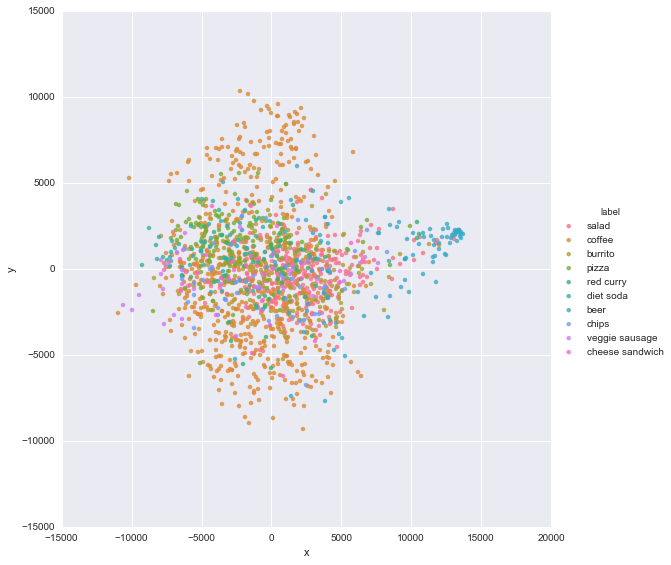

In [128]:
sns.lmplot('x', 'y', data=df, hue='label', fit_reg=False, size=8)

#### Generate the Training and Test Data

In [129]:
n_components = 10
# pca = RandomizedPCA(n_components=n_components)
pca = PCA(n_components=n_components)

In [130]:
X = img_data
y = classes

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [132]:
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

#### Run the Predictions!

In [133]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()

In [140]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

#### Diagnostics

In [141]:
from sklearn.cross_validation import cross_val_score

In [142]:
y_pred = knn.predict(X_test)

In [143]:
tab = pd.crosstab(y_test, y_pred, rownames=['actual'], colnames=['predicted'])

In [144]:
tab.index = labels
tab.columns = labels

In [145]:
tab

,salad,coffee,burrito,pizza,red curry,diet soda,beer,chips,veggie sausage,cheese sandwich
salad,80,2,7,1,1,0,3,0,2,1
coffee,14,126,5,2,0,0,1,0,1,0
burrito,11,7,26,1,0,0,0,0,0,0
pizza,12,2,5,26,0,0,0,0,1,0
red curry,4,3,0,2,2,0,0,0,0,0
diet soda,0,3,1,0,0,10,0,0,0,0
beer,5,7,3,0,0,0,8,1,0,0
chips,5,1,5,1,0,0,0,1,0,0
veggie sausage,1,2,1,0,0,0,0,0,5,0
cheese sandwich,3,3,5,1,0,1,0,0,0,0


In [146]:
cross_val_score(knn, X_test, y_test).mean()

0.59557312787239802

In [24]:
# clf.fit(X_train, y_train)